# MADRID CENTRAL

[TODO] Add table of contents + intro here

## Imports

Different libraries and functions we require to run the code

In [60]:
import pandas as pd
from matplotlib.path import Path
import numpy as np
import seaborn as sns
import time
from datetime import datetime as dt
import utm
import json
from tqdm import tqdm
import requests
import zipfile
import os, io
import glob
import webbrowser
from IPython.display import display
from collections import defaultdict
import matplotlib.pyplot as plt

# folium
import folium
import folium.plugins

# animated Folium map
import folium
from folium import plugins
from folium.plugins import TimestampedGeoJson

# bokeh
import bokeh.palettes
from bokeh.plotting import figure, show, output_file, save, reset_output
from bokeh.io import output_notebook
from bokeh.models import HoverTool, Legend, ColumnDataSource, Span, ColorBar, DatetimeTickFormatter, CustomJS, Button, FactorRange
from bokeh.models.widgets import Panel, Tabs
from bokeh.tile_providers import get_provider, CARTODBPOSITRON
from bokeh.layouts import layout
from bokeh.transform import linear_cmap, factor_cmap


output_notebook()
np.random.seed(42)

Loading BokehJS ...

## Auxiliar Functions

In [2]:
def get_color_from_palette(color):
    """ Getting colors for plotting """
    return tuple([int(c * 255) for c in color])

def get_dark_color_from_palette(color):
    """ Getting darker colors for plotting """
    return tuple([int(c * 200) for c in color])

## Constants

Different constants to use through the code.

In [3]:
DOWNLOAD_TRAFFIC_DATA = False # Dowload or not the traffic data
GENERATE_TRAFFIC_DATA = False # Generate traffic data

DOWNLOAD_AIR_QUALITY_DATA = False # Dowload or not the air quality data
PROCESS_AIR_QUALITY_DATA = False # Process previously downloaded air quality data (if not: we download it from Google Drive)

SAVE_PLOTS = False # If true, save the bokeh plots as html. Othewise, show

# Colors for the plots
PALETTE = "colorblind"

DISTRICT_COLORS = [
    get_color_from_palette(c)
    for c in sns.color_palette(PALETTE, 21)
    ]

DISTRICT_DARK_COLORS = [
    get_dark_color_from_palette(c)
    for c in sns.color_palette(PALETTE, 21)
    ]

MADRID_IN_OUT_COLORS = [
    get_color_from_palette(c)
    for c in sns.color_palette(PALETTE, 2)
    ]

MADRID_IN_OUT_DARK_COLORS = [
    get_dark_color_from_palette(c)
    for c in sns.color_palette(PALETTE, 2)
    ]

# Madrid Central key dates
START_DATE = dt(2018, 11, 30, 0, 0, 0)
FINES_DATE = dt(2019, 3, 15, 0, 0, 0)
END_DATE = dt(2019, 7, 1, 0, 0, 0)

START_MC = time.mktime(START_DATE.timetuple())*1000
FINES_MC = time.mktime(FINES_DATE.timetuple())*1000
END_MC = time.mktime(END_DATE.timetuple())*1000

## 1. Motivation

The purpose of our project is to analyze the real impact of the measure that took place in the city center of Madrid called **Madrid Central**.

To sum up, Madrid Central was an environment measure that entered in force the **30th of November 2018**, it prohibited all polluting vehicles from entering the *"Centro"* district of Madrid. Unfortunately, it was taken down for political and economic reasons the **1st of July 2019**. 

In this study, we aim to evaluate the effectiveness of this vehicle regulation on pollution by analyzing traffic and air quality.

More on **Madrid Central** on the webpage.

<div align="center">
  <img src="https://s03.s3c.es/imag/_v0/864x1252/2/7/c/Madrid-Central_Plano-con-logo.jpg" alt="Madrid Central"/>
</div>

### The Dataset

We use multiple datasets, all of them from the **Open Data platform of the Town hall of Madrid**. 

<div align="center">
  <img src="https://www.zupimages.net/up/22/18/htou.png" alt="Open Data Madrid"/>
</div>


The datasets we use are:

 - **Air Quality Data**
    - [*Calidad del aire. Datos horarios desde 2001* (*Air quality. Hourly data since 2001*)](https://datos.madrid.es/sites/v/index.jsp?vgnextoid=f3c0f7d512273410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD):
    
      This data has in each file different air quality measures from multiple measurement stations. There are 24 stations all around the city of Madrid, with different gases measured in each one of them.

    - [*Calidad del aire. Estaciones de control* (*Air quality. Control stations*)](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=9e42c176313eb410VgnVCM1000000b205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default):
    
      This is the geodata related to the measurement points. For plotting using Bokeh we had to change the format of how the spatial coordinates are presented.

 - **Traffic Data**
    - [*Tráfico. Histórico de datos del tráfico desde 2013* (*Traffic. Historic traffic data since 2013*)](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=33cb30c367e78410VgnVCM1000000b205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default):
    
      This data has in separated files the recorded traffic measurements from more than 3000 points, taken every 15 minutes. This is the core dataset we use for our traffic analysis, but, to reduce the size of the data, we preprocess it to only use the average measure on each point per day.
    
    - [*Tráfico. Ubicación de los puntos de medida del tráfico* (*Traffic. Location of traffic measurement points*)](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=ee941ce6ba6d3410VgnVCM1000000b205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD):
    
      This is the geodata related to the measurement points. For plotting using Bokeh we had to change the format of how the spatial coordinates are presented.

 - **Districts Geodata**

   - [*Distritos municipales de Madrid* (*Municipal districts of Madrid*)](https://datos.madrid.es/sites/v/index.jsp?vgnextoid=7d6e5eb0d73a7710VgnVCM2000001f4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD):
   
      The data has geodata of the limits of each of the districts of Madrid


### The Reason of the Dataset

We decided on these two datasets because we wanted to discover if **Madrid Central** achieved the objectives of reducing air pollution in the area, and we also wanted to inspect how effective and how big was the change in the traffic in and out of **Madrid Central**.

Additionally, we desired to analyze the relation between air quality and traffic in the city of Madrid.

### User Experience

While investigating this topic, we saw a lot of articles about **Madrid Central**. Some of them, saying how good and beneficial it was. Others, saying the exact opposite. Sadly, most of the news and articles were quite influenced by political ideas. This is because the measure was imposed by a political party, against the wishes of the opposing political party. Therefore, we feel they were biased, and did not rely on data and science.

We aim to fix this, trying to give an answer to how effective the measure really was, based on data, using visualizations and data analysis. We also want to present this in an informative and interactive way.

## 2. Basic Stats

### Data Processing

The first thing that has to be done in any data related task, is to preprocess and clean the data. In our case, this is very important, as we have as baseline many different files, with a lot of information. We have to reduce the dataset to obtain only the relevant parts.

**Air quality Data Processing**

Let's start by downloading all the air quality data directly from the Open Data Portal database of Madrid.

In [ ]:
def download_air_quality_data():
    """ Download all air quality data from 2016 until 2020.
        Each file has a unique year id, we provide them in ID_list.
        The name convention is 
        'https://datos.madrid.es/egob/catalogo/201200-{id}-calidad-aire-horario.zip'
        In each ZIP file, we only extract the csv file of each month
    """
    ID_list = {
        2016:28, 
        2017:10306313, 
        2018:10306314, 
        2019:42,
        2020:10306316
    }
    
    DATA_PATH = "data"
    
    for year, year_id in tqdm(ID_list.items(), desc="Downloading air quality data", unit="file"):
        url = f"https://datos.madrid.es/egob/catalogo/201200-{year_id}-calidad-aire-horario.zip"
        r = requests.get(url)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        for zipFile in z.infolist():
            if (zipFile.filename.split('.')[-1] == 'csv'):
                month_letters = zipFile.filename[:3]
                # If it has been downloaded already, skip it
                file_path = f"{DATA_PATH}/air-quality-{month_letters}-{year}-raw.csv"
                if not os.path.isfile(file_path):
                    # Rename file
                    zipFile.filename = file_path
                    # Extract file
                    z.extract(zipFile)

if DOWNLOAD_AIR_QUALITY_DATA:
    download_air_quality_data()

Once we downloaded the data, we need to process it in order to obtain a suitable format for upcoming visualisations.
Indeed, each monthly CSV file contains one column for each hour with a associated validation column (see [the Air Quality Data documentation](https://datos.madrid.es/FWProjects/egob/Catalogo/MedioAmbiente/Aire/Ficheros/Interprete_ficheros_%20calidad_%20del_%20aire_global.pdf) for more details - in Spanish). Eventually we want a dataset the following columns only: date/time, localisation (e.g. corresponding air quality station), gas formula and corresponding gas concentration.

For this purpose, we need to apply the following steps on each monthly file:
1. Drop the validation columns (we consider all values as validated to facilitate the process)
2. Get only one HOUR column by melting the dataset
3. Generate the `datetime` column
4. Keep only the air quality station ID of each measure

Then we can concatenate all monthly dataframes into one final dataset: `air_quality_data.csv`.

**WARNING: the following air quality data processing takes time (about 25 minutes)!**

**If you just want to get the final `air_quality_data.csv` file, set `PROCESS_AIR_QUALITY_DATA = False`**

In [ ]:
if PROCESS_AIR_QUALITY_DATA:
    def format_time(aRow):
        """ Generate a datetime format based on ANO, MES, DIA and HOUR """
        hour = int(aRow.HOUR[1:])
        if hour != 0: 
            # special case: midnight >> H24 == H00 for the day before
            return pd.to_datetime(dt(aRow.ANO, aRow.MES, aRow.DIA, hour))
        return pd.to_datetime(dt(aRow.ANO, aRow.MES, aRow.DIA, hour)+timedelta(days=1))

    def format_PUNTO_MUESTREO(aRow):
        """ The format of PUNTO_MUESTRO data is: {ID}_{magnitud}_{technical ID}.
        We are only interested in the ID of the air quality station"""
        return int(aRow.PUNTO_MUESTREO.split('_')[0])

    def dms2dd(s):
        """ From DMS (ex: 3º 42' 25.64'' O) to Longitude, Latitude"""
        degrees, minutes, seconds, direction = re.split('[° \' " ]+', s)
        dd = float(degrees[:-1]) + float(minutes)/60 + float(seconds)/(60*60);
        if direction in ('S','O'):
            dd*= -1
        return dd

    def format_lonlat(aRow):
        return pd.Series([dms2dd(aRow.longitude), dms2dd(aRow.latitude)])

    def dd2UTM(lat, lon):
        """ From Lat, Lon to UTM """
        r_major = 6378137.000
        x = r_major * np.radians(lon)
        scale = x/lon
        y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + 
            lat * (np.pi/180.0)/2.0)) * scale
        return x, y

    def format_utm(aRow):
        x, y = dd2UTM(aRow.latitude, aRow.longitude)
        return pd.Series([x,y])

    def process_air_quality_csv(aCSVFileName):
        # load as dataframe
        df = pd.read_csv(aCSVFileName, sep=';')
        columns = df.columns.values
        # drop validation columns
        # NOTE: WE CONSIDER ALL DATA AS VALIDATED
        df = df.drop(columns[[s.startswith('V') for s in columns]], axis=1)
        # melt hours into one column
        df = pd.melt(df, 
            id_vars = ['PROVINCIA','MUNICIPIO','ESTACION','MAGNITUD','PUNTO_MUESTREO','ANO','MES','DIA'], 
            value_name = 'value', var_name='HOUR')
        # replace H24 per H00
        df = df.replace('H24','H00')
        # generate the timestamp column
        df['datetime'] = df.apply(format_time, axis=1)
        # format PUNTO_MUESTREO to keep the code only
        df['PUNTO_MUESTREO'] = df.apply(format_PUNTO_MUESTREO, axis=1)
        # drop useless time columns
        df = df.drop(['ANO','MES','DIA','HOUR'], axis=1)
        return df
    
    # process and export all csv
    DATA_PATH = 'data/'
    for filename in tqdm(glob.iglob(DATA_PATH + 'air-quality-*-raw.csv'), desc="Processing air quality data", unit="file"):
        name = filename.split('\\')[1]
        new_name = name[:-8] +'.csv'
        df_processed = process_air_quality_csv(DATA_PATH+name)
        df_processed.to_csv(DATA_PATH+new_name, index=False, encoding='utf-8')
        os.remove(DATA_PATH+name)

    # gather all processed files in one csv
    all_dfs = []
    for filename in tqdm(glob.iglob(DATA_PATH + 'air-quality-*.csv'), desc="Merging air quality data", unit="file"):
        name = filename.split('\\')[1]
        all_dfs.append(pd.read_csv(DATA_PATH+name))
        os.remove(DATA_PATH+name)

    df_air_quality = pd.concat(all_dfs, axis=0)
    df_air_quality.to_csv('air_quality_data.csv', index=False)
    
else:
    webbrowser.open('https://drive.google.com/uc?export=download&id=1Xh6Ce9mBVx2A1NqG8SUe4yUX_voswct8', new=2)

We can then join the air quality data with the air quality stations and air information tables:

In [4]:
# load air quality stations
df_stations = pd.read_csv('shared_data/air_quality/air_quality_stations.csv')
# load gas infos table
df_gas = pd.read_csv('shared_data/air_quality/air_quality_magnitud.csv', sep=';')
df_gas['unit_per_m3_original'] = df_gas['unit_per_m3']
# load air quality data
df_air = pd.read_csv('data/air_quality_data.csv')
# converting Date to datetime type
df_air["datetime"] = pd.to_datetime(df_air["datetime"])
# merge with air quality stations
df_air = pd.merge(df_air, df_stations, left_on = 'PUNTO_MUESTREO', right_on='punto_muestreo', how='left').drop('PUNTO_MUESTREO', axis=1)
# merge with air quality recorded gas
df_air = pd.merge(df_air, df_gas, left_on = 'MAGNITUD', right_on='magnitud_id', how='left').drop('MAGNITUD', axis=1)

# restrict up to February 2020 included
df_air = df_air[(df_air['datetime'] < pd.to_datetime('2020-02-29 23:59:59'))]
# remove negative values = errors
df_air = df_air[(df_air.value > 0) ]

df_air.head()

,PROVINCIA,MUNICIPIO,ESTACION,value,datetime,punto_muestreo,name,longitude,latitude,altitude,utm_x,utm_y,magnitud_id,formula,unit_per_m3,european_standard,unit_per_m3_original
0,28,79,4,7.0,2016-04-01 01:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,1,SO2,µg,125,µg
1,28,79,4,8.0,2016-04-02 01:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,1,SO2,µg,125,µg
2,28,79,4,10.0,2016-04-03 01:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,1,SO2,µg,125,µg
3,28,79,4,7.0,2016-04-04 01:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,1,SO2,µg,125,µg
4,28,79,4,8.0,2016-04-05 01:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,1,SO2,µg,125,µg


Boxplots of traffic data to track outliers:

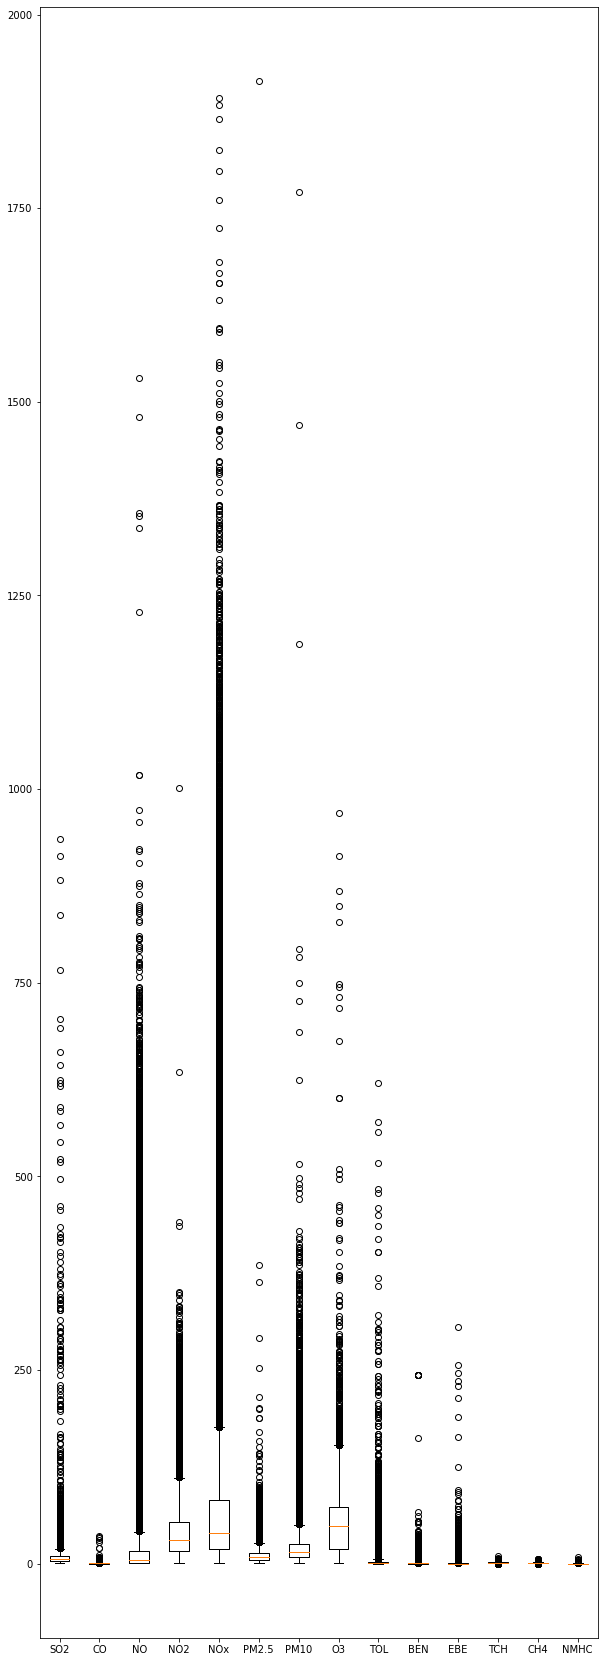

In [129]:
all_gases = df_air.formula.unique()
plt.figure(figsize=(10,30))
plt.boxplot([df_air[(df_air.formula==(aGas)) & (df_air['value']<2000) ]['value'].values for aGas in all_gases])
plt.xticks(range(1, len(all_gases)+1), all_gases)
plt.show()

**Traffic Data Processing**

The data we want to work with is very large, thus we need to download it from the source as it is not possible to upload it to the version control system we use (GitHub). 

In [ ]:
def download_data_traffic():
    """ Download all traffic data from January 2016 (ID=32) until February 2020 (ID=81)
        Some files do not follow the same naming convention, and need repairing.
        The name convention that most files follow is '{num_month}-{num_year}.yaml',
        so everyone will follow that
    """
    FIRST_MONTH_ID = 32
    LAST_MONTH_ID = 81
    DATA_PATH = "data/traffic2"
    
    for month_id in tqdm(range(FIRST_MONTH_ID, LAST_MONTH_ID+1), desc="Downloading data", unit="file"):
        
        # Get month number, from 1 to 12
        current_month = ((month_id - FIRST_MONTH_ID) % 12) + 1
        
        # Get year number, from 2016 to 2021
        current_year = int((month_id - FIRST_MONTH_ID) / 12) + 2016    
               
        # If it has been downloaded already, skip it

        file_path = f"{DATA_PATH}/{current_month:02d}-{current_year}.csv"

        if not os.path.isfile(file_path):

            url = f"https://datos.madrid.es/egob/catalogo/208627-{month_id}-transporte-ptomedida-historico.zip"
            r = requests.get(url)
            z = zipfile.ZipFile(io.BytesIO(r.content))
            zipcsv = z.infolist()[-1]
            
            # Rename file
            zipcsv.filename = file_path
            
            # Extract file
            z.extract(zipcsv)
            

if DOWNLOAD_DATA:
    download_data_traffic()

Before diving into the actual data, we need to contextualize. Madrid is divided into districts. There are *21* one of them, being the area of **Madrid Central** exactly the same as the **Centro district** area (thus the name).

We have a dataset of where the measure of traffic points are located. As expected, they are not evenly distributed. Our first task is to see in which district each traffic measurement point is located.

In [ ]:
traffic_points = pd.read_csv("shared_data/traffic_points/pmed_trafico_03052016.csv", sep=";")
traffic_points.head()

First we need to calculate the correct *utm* for displaying in `bokeh` maps.

In [ ]:
def utm_from_latlon(lat, lon):
    """ From a given lat and lon, calculates the correct UTM coordinates to 
        plot using `bokeh` 
    """
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x/lon
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + 
        lat * (np.pi/180.0)/2.0)) * scale

    return x, y

def get_lat_lon_utm(row):
    """ From a row containing the columns 'st_x' and 'st_y' calculates both the lat and lon
        and the correct UTM coordinates to plot using `bokeh`
    """

    # 30 and 'T' is the zone of Madrid
    lat, lon = utm.to_latlon(row["st_x"], row["st_y"], 30, "T")
    
    x, y = utm_from_latlon(lat, lon)

    return pd.Series([lat, lon, x, y])

In [ ]:
traffic_points[["latitude", "longitude", "utm_x", "utm_y"]] = traffic_points.apply(get_lat_lon_utm, axis=1)
traffic_points = traffic_points.rename(columns = {'nombre':'name'})
traffic_points.head()

Then load the districts information to display them in the map.

In [ ]:
with open("shared_data/districts/districts.geojson", "r") as geojson:
    geodata = json.load(geojson)

In [ ]:
df_districts = pd.DataFrame([], columns=["name", "latitude",
                                         "longitude", "utm_x",
                                         "utm_y"])
for district in geodata["features"]:
    # Get district name
    district_name = district["properties"]["NOMBRE"]
    
    # Get district coordinates
    district_coord = district["geometry"]["coordinates"][0]
    df_district = pd.DataFrame(district["geometry"]["coordinates"][0], columns=["st_x", "st_y"])
    df_district["name"] = district_name
    
    # Calculate correct utm
    df_district[["latitude", "longitude", "utm_x", "utm_y"]] = df_district.apply(get_lat_lon_utm, axis=1)
    df_district = df_district.drop(columns=["st_x", "st_y"])
    
    # Append to all districts dataframe
    df_districts = pd.concat([df_districts, df_district]).reset_index(drop=True)


district_name = df_districts["name"].unique()
df_districts

Save in which district is each traffic point.

In [ ]:
traffic_points["district"] = "None"
points = traffic_points[["utm_x", "utm_y"]]

for name in district_name:
    path = Path(df_districts[df_districts["name"] == name][["utm_x", "utm_y"]])
    points_in_path_mask = path.contains_points(points)
    traffic_points.loc[points_in_path_mask, "district"] = name

# Discard the traffic points outside any district of Madrid, as they are outside the city
    
traffic_points = traffic_points.drop(traffic_points[traffic_points["district"] == "None"].index)\
                .reset_index(drop=True)

traffic_points.head()

The next step is to load the datasets for traffic information. This datasets have a lot of rows, as each of the more than 3000 measurement points record mutiple parameters each 15 minutes, so a rough approximation of how many rows each month file has is:

$$ 30(days) \cdot 24(hours) \cdot 4(measures\_per\_hour) \cdot 3000(traffic\_points) = 8640000 $$

And once again, if we take into account that we are using data from 2016 until the end of 2021, a more accurate row count would be:

$$ 4(years) \cdot 365(days) \cdot 24(hours) \cdot 4(measures\_per\_hour) \cdot 3000(traffic\_points) = 42048000 $$

This amount of data (more than 630 million rows) is too much to handle efficiently, and obtain relevant information. To reduce the amount of rows, we decide on keeping the average intensity of traffic (Number of cars) per day in each district. That way, we will have:

$$ 4(years) \cdot 365(days) \cdot 21(number\_districts) = 30660 $$

which is more manageable number, from where we aspire to detect the relevant information in the data. Around 13714 times less data.

In [ ]:
def process_traffic_data(filepath, traffic_points_df):
    """ Function to process each traffic data file. This preoprocess has as objective to reduce
        the dimensionality od the data, only keeping one value per district per day, reducing this
        way the number of rows to handle.
        
        Arguments:
            filepath          -> path to load the csv
            traffic_points_df -> traffic_points dataset (where they are located)
    """
    
    # Load file
    traffic_df = pd.read_csv(filepath, sep=";")
    
    # For god knows why, there is one file that is separated by ',' instead of ';'
    # so we reread the file if it only has one column
    if len(traffic_df.columns) == 1:
        traffic_df = pd.read_csv(filepath, sep=",")
    
    # If the 'idelem' column does not exists, is because is called 'id', so rename column
    if "idelem" not in traffic_df.columns:
        traffic_df = traffic_df.rename(columns = {'id':'idelem'})
    
    # Use only the traffic points for whom we have information 
    traffic_df = traffic_df[traffic_df["idelem"].isin(traffic_points_df["idelem"])]
    
    # Transform date to datime type
    traffic_df["fecha"] = pd.to_datetime(traffic_df["fecha"])
    
    # Get date in separate columns
    traffic_df["day"] = traffic_df["fecha"].dt.day
    traffic_df["month"] = traffic_df["fecha"].dt.month
    traffic_df["year"] = traffic_df["fecha"].dt.year

    # Group by id and date, up to day, and get the average intensity perr traffic point
    traffic_df = traffic_df.groupby(["idelem",
                                     "day",
                                     "month",
                                     "year"]).agg(mean_intensity=("intensidad", "mean")).reset_index()
    
    # Merge with the traffic points to get the district for each point
    traffic_df = traffic_df.merge(traffic_points_df[["idelem", "district"]], on="idelem")
    
    # Save also the traffic points as separated files
    traffic_points_intensity_df = traffic_df.copy()

    # Group by again, to get only one value per district per day
    traffic_df = traffic_df.groupby(["district", "day", "month", "year"]).mean()["mean_intensity"].reset_index()
    
    # Get the date and day of the week for plotting purpose
    traffic_df["date"] = pd.to_datetime(traffic_df[["day", "month", "year"]])
    traffic_df["day_of_week"] = traffic_df["date"].dt.day_name()

    traffic_points_intensity_df["date"] = pd.to_datetime(traffic_points_intensity_df[["day", "month", "year"]])
    traffic_points_intensity_df["day_of_week"] = traffic_points_intensity_df["date"].dt.day_name()

    # Save idelem as integer
    traffic_points_intensity_df["idelem"] = traffic_points_intensity_df["idelem"].astype(int)
    
    return traffic_df, traffic_points_intensity_df

In [ ]:
def load_all_trafic_data(traffic_points_df):
    """ Function to load all trafic data from the data folder,
        after being processed
        
        Arguments:
            traffic_points_df -> traffic_points dataset (where they are located)
    """
    
    DATA_PATH = "data/traffic"
    
    traffic_data = pd.DataFrame([], columns=["district", "date", "day_of_week",
                                             "day", "month", "year", "mean_intensity"])
    
    traffic_points_data = pd.DataFrame([], columns=["district", "date", "day_of_week",
                                             "day", "month", "year", "mean_intensity"])
    
    for filepath in tqdm(os.listdir(DATA_PATH), desc="Processing files", unit="file"):
        traffic_df, traffic_points_intensity_df= process_traffic_data(os.path.join(DATA_PATH, filepath), traffic_points_df)
        
        traffic_data = pd.concat([traffic_data, traffic_df])
        traffic_points_data = pd.concat([traffic_points_data, traffic_points_intensity_df])


    return (traffic_data.sort_values(by=["district", "date"]).reset_index(drop="True"),
            traffic_points_data.sort_values(by=["district", "date", "idelem"]).reset_index(drop="True"))

In [ ]:
df_traffic_path = "shared_data/traffic_intensity.csv"
df_traffic_intensity_path = "data/traffic_points_intensity.csv"


if not GENERATE_TRAFFIC_DATA:
    total_traffic_df = pd.read_csv(df_traffic_path)
    total_traffic_df["date"] = pd.to_datetime(total_traffic_df["date"])

    traffic_points_intensity_df = pd.read_csv(df_traffic_intensity_path)
    traffic_points_intensity_df["date"] = pd.to_datetime(traffic_points_intensity_df["date"])
    traffic_points_intensity_df["idelem"] = traffic_points_intensity_df["idelem"].astype(int)
else:
    total_traffic_df, traffic_points_intensity_df = load_all_trafic_data(traffic_points)

    total_traffic_df.to_csv(df_traffic_path, index=False)
    traffic_points_intensity_df.to_csv(df_traffic_intensity_path, index=False)

In [ ]:
total_traffic_df.head()

In [ ]:
traffic_points_intensity_df.head()

### Exploratory data analysis

**Air quality data exploration**

Let's start by plotting the air quality stations on a map to get a better idea of their location.

In [5]:
print(f'There are {len(df_stations.name.unique())} air quality stations in Madrid:')
print(', '.join(df_stations.name.unique()))

There are 24 air quality stations in Madrid:
Plaza del Carmen, Plaza de España, Barrio del Pilar, Escuelas Aguirre, Cuatro Caminos, Ramón y Cajal, Vallecas, Arturo Soria, Villaverde, Farolillo, Moratalaz, Casa de Campo, Barajas Pueblo, Méndez Álvaro, Castellana, Retiro, Plaza Castilla, Ensanche de Vallecas, Urbanización Embajada, Plaza Elíptica, Sanchinarro, El Pardo, Juan Carlos I, Tres Olivos


In [6]:
# load MC area
cm_points = pd.read_csv('shared_data/districts/central_madrid_points.csv')

# add is_in_MC column for each air quality station
points = df_stations[["utm_x", "utm_y"]].values
path = Path(cm_points[["utm_x", "utm_y"]].values)
points_in_path_mask = path.contains_points(points)
df_stations["is_in_MC"] = False
df_stations.loc[points_in_path_mask, "is_in_MC"] = True

# plot map
p = figure(title="Air quality stations in Madrid", x_axis_type="mercator", y_axis_type="mercator")

source_in, source_out = ColumnDataSource(df_stations[df_stations.is_in_MC==True]), ColumnDataSource(df_stations[df_stations.is_in_MC==False])
cr_in = p.circle(x="utm_x", y="utm_y",  size=10, color=MADRID_IN_OUT_COLORS[0], source=source_in)
cr_out = p.triangle(x="utm_x", y="utm_y",  size=10, color=MADRID_IN_OUT_COLORS[1], source=source_out)

# Madrid Central lines
source_mc = ColumnDataSource(cm_points)
line_cm = p.line(x="utm_x", y="utm_y", color=MADRID_IN_OUT_COLORS[0], line_width=2, 
        source=source_mc, muted=False, muted_alpha=0.3)

cartodb = get_provider(CARTODBPOSITRON)
p.add_tile(cartodb)

p.add_tools(HoverTool(tooltips=[('Name', '@name')], renderers=[cr_in, cr_out]))

# add interactive legend
legend = Legend(items=[('Madrid Central Area', [line_cm]), ('IN Madrid Central area', [cr_in]), ('OUT of Madrid Central area', [cr_out])], location='center') 
legend.click_policy="hide"
legend.location = "top_left"
p.add_layout(legend)

if SAVE_PLOTS:
    output_file("html_plots/air_quality_stations.html")
    save(p)
    reset_output()
    output_notebook()
else:
    show(p)

Let's visualise air quality data of givens stations over time.

In [7]:
def get_month_year(aRow):
    return aRow.name.month_name() + ' ' + str(aRow.name.year)

def get_stats_dataframe(station):
    df1 = df_air[(df_air.name == station)][['formula','value','datetime']]
    df1 = df1.pivot(index='datetime', columns='formula', values='value').reset_index()
    df1['datetime'] = df1.datetime.dt.floor('D')
    df1['datetime'] = df1['datetime'].apply(lambda dt: dt.replace(day=1))
    tracking_gas = df1.columns.values[1:]
    # cut outliers!!!
    if station == 'Plaza del Carmen':
        df1 = df1[df1.SO2 <500 ]
        df1 = df1[df1.CO < 10 ]
    # homogenization (everything in µg/m^3)
    for aGas in df1.columns.values[1:]:
        unit = df_gas[df_gas.formula==aGas].unit_per_m3.values[0]
        if ((unit == 'mg') or (unit == '10μg')):
            # we change to 10
            df1[aGas] = df1[aGas] * 100 #*1000 to get it in μg/m3 exactly
            idx = df_gas[df_gas.formula==aGas].index
            df_gas.loc[idx, 'unit_per_m3'] = '10μg'
    # get all stats
    df1_stats = df1.groupby(['datetime']).agg(['mean','std'])
    df1_stats.columns = df1_stats.columns.to_flat_index()
    df1_stats.columns = pd.Index([a+'_'+b for a,b in df1_stats.columns])
    df1_stats['date'] = df1_stats.apply(get_month_year, axis=1)
    for aGas in tracking_gas:
        meanColumn = aGas+'_mean'
        stdColumn = aGas+'_std'
        df1_stats[aGas+'_upper'] = df1_stats[meanColumn]+df1_stats[aGas+'_std']
        df1_stats[aGas+'_lower'] = df1_stats[meanColumn]-df1_stats[aGas+'_std']
    return tracking_gas, df1_stats

def get_bokeh_viz_evolution_over_time(df1_stats, aText, tracking_gas):

    # create annotations for time marks
    startMC_span = Span(location=START_MC,
                                dimension='height', line_color='black',
                                line_dash='dashed', line_width=2, line_alpha=0.3)
    finesMC_span = Span(location=FINES_MC,
                                dimension='height', line_color='black',
                                line_dash='dashed', line_width=2, line_alpha=0.3)
    endMC_span = Span(location=END_MC,
                                dimension='height', line_color='black',
                                line_dash='dashed', line_width=2, line_alpha=0.3)

    cds_stats = ColumnDataSource(data=df1_stats)

    p = figure(
        x_axis_type="datetime",
        width=950,
        height=450,
        title='Evolution of pollutant concentrations over time in '+aText, 
        y_axis_label='Gas Concentration', 
        x_axis_label='Date'
    )

    # create color palette
    colors_gas = dict(zip(tracking_gas,list(bokeh.palettes.brewer['Dark2'][len(tracking_gas)])))

    # add the data of each gas + interactive legend
    lines, circles, bands = {}, {}, {}
    items = [] 
    for aGas in tracking_gas:
        unit = df_gas[df_gas.formula==aGas].unit_per_m3.values[0]
        # add line of mean
        lines[aGas] = p.line('datetime', aGas+'_mean', source=cds_stats, color = colors_gas[aGas])
        # add dots of mean
        circles[aGas] = p.circle('datetime',aGas+'_mean', source=cds_stats, color=colors_gas[aGas], size=5, alpha=0.5)
        p.add_tools(HoverTool(tooltips=[
            ('Gas',aGas),
            ('Date', '@date'),
            ('Average value', f'@{aGas}_mean {unit}/m3'), 
            ('Standard Deviation', f'@{aGas}_std {unit}/m3')
        ], renderers=[circles[aGas]]))
        # add variance
        bands[aGas] = p.varea(x='datetime', y1=aGas+'_upper', y2=aGas+'_lower', source=cds_stats, fill_alpha=0.1, fill_color=colors_gas[aGas])
        # append legend list
        items.append((f'{aGas} ({unit}/m3)', [lines[aGas], circles[aGas], bands[aGas]]))

    # add legend
    legend = Legend(items=items, location='center') 
    legend.click_policy="hide"
    legend.location = 'top_left'
    p.add_layout(legend)

    # add annotations to plot
    p.add_layout(startMC_span)
    p.add_layout(finesMC_span)
    p.add_layout(endMC_span)
    
    return layout(p, sizing_mode='stretch_both')

def get_bokeh_tabs_air_stations(aListOfStations):
    tabs = []
    for station in aListOfStations:
        all_tracking_gas, df_stats_station = get_stats_dataframe(station)
        p = get_bokeh_viz_evolution_over_time(df_stats_station, station, all_tracking_gas)
        tabs.append(Panel(child=p, title=station))
    return Tabs(tabs=tabs)

In [8]:
stations = ['Plaza del Carmen', "Plaza de España", "Castellana", "Retiro", "Méndez Álvaro"]

# get Bokeh visualisation with a tab for each required air quality station
tabs = get_bokeh_tabs_air_stations(stations)

if SAVE_PLOTS:
    output_file("html_plots/air_quality_evolution_tabs.html")
    save(tabs)
    reset_output()
    output_notebook()
else:
    show(tabs)

To get a better idea of the air quality progress in a given location over time, let's plot the evolution based on the month of the previous year for recorded pollutants.

In [9]:
def get_df_comparison(station):
    
    def get_progress_percent(aRow):
        previousRow = df2_mean[(df2_mean.month==aRow.month) & (df2_mean.year==aRow.year-1)]
        if len(previousRow) != 0:
            previousRow = previousRow.iloc[0]
            ratios = 100*(aRow - previousRow)/previousRow
            datetime_to_keep = aRow.name
            ratios.name = datetime_to_keep
            ratios.month = datetime_to_keep.month
            ratios.year = datetime_to_keep.year
            return ratios
        return None

    df1 = df_air[(df_air.name == station)][['formula','value','datetime']]
    df1 = df1.pivot(index='datetime', columns='formula', values='value').reset_index()
    df1['datetime'] = df1.datetime.dt.floor('D')
    df1['datetime'] = df1['datetime'].apply(lambda dt: dt.replace(day=1))
    tracking_gas = df1.columns.values[1:]
    
    # cut outliers!!!
    if station == 'Plaza del Carmen':
        df1 = df1[df1.SO2 <500 ]
        df1 = df1[df1.CO < 10 ]

    # get mean
    df2_mean = df1.groupby(['datetime']).mean().reset_index()
    df2_mean = df2_mean.set_index('datetime')
    df2_mean["month"] = df2_mean.index.month
    df2_mean["year"] = df2_mean.index.year

    # get percentage
    df2_ratios = df2_mean[df2_mean.year > 2016].apply(get_progress_percent, axis=1)

    # get date display
    df2_ratios['date'] = df2_ratios.apply(get_month_year, axis=1)
    
    return tracking_gas, df2_ratios

def get_bokeh_viz_ratios(df2_ratios, aText, tracking_gas):
    # create annotations for time marks
    startMC_span = Span(location=START_MC,
                                dimension='height', line_color='black',
                                line_dash='dashed', line_width=2, line_alpha=0.3)
    finesMC_span = Span(location=FINES_MC,
                                dimension='height', line_color='black',
                                line_dash='dashed', line_width=2, line_alpha=0.3)
    endMC_span = Span(location=END_MC,
                                dimension='height', line_color='black',
                                line_dash='dashed', line_width=2, line_alpha=0.3)
    
    cds_ratios = ColumnDataSource(data=df2_ratios)
    
    # create color palette
    colors_gas = dict(zip(tracking_gas,list(bokeh.palettes.brewer['Dark2'][len(tracking_gas)])))

    p = figure(
        width=950, 
        height=450, 
        x_axis_type="datetime",
        title='Comparisons of pollutant concentrations with the month of previous year in '+aText, 
        y_axis_label='+/- percentage based on the previous month', 
        x_axis_label='Date'
    )

    # add the data of each gas + interactive legend
    items = [] 
    lines, circles = {}, {}
    for aGas in tracking_gas:
        unit = df_gas[df_gas.formula==aGas].unit_per_m3.values[0]
        # add line
        lines[aGas] = p.line('datetime', aGas, source=cds_ratios, color = colors_gas[aGas])
        # add dots
        circles[aGas] = p.circle('datetime',aGas, source=cds_ratios, color=colors_gas[aGas], size=5, alpha=0.3)
        p.add_tools(HoverTool(tooltips=[
            ('Gas',aGas),
            ('Date', '@date'),
            ('Previous Month comparison','@'+aGas+'%')
        ], renderers=[circles[aGas]]))
        # append legend item
        items.append((f'{aGas} ({unit}/m3)', [lines[aGas], circles[aGas]]))

    # add annotations to plot
    p.add_layout(startMC_span)
    p.add_layout(finesMC_span)
    p.add_layout(endMC_span)

    # add "zero" annotation
    zero_line_span = Span(location=0, dimension='width', line_color='red', line_width=1, line_alpha=0.3)
    p.add_layout(zero_line_span)

    legend = Legend(items=items) 
    legend.click_policy="hide"
    legend.location = 'top_left'
    p.add_layout(legend)
    p = layout(p, sizing_mode='stretch_both')
    
    return p

def get_bokeh_viz_ratios_listStations(stations):
    df_ratios = []
    all_stations_gases = []

    for aStation in stations:
        all_tracking_gas, df_ratios_station = get_df_comparison(aStation)
        df_ratios.append(df_ratios_station)
        if len(all_stations_gases) == 0:
            all_stations_gases = np.array(all_tracking_gas)
        else:
            all_stations_gases = np.intersect1d(all_stations_gases, np.array(all_tracking_gas))

    df_ratios = pd.concat(df_ratios)
    df_ratios.dropna(axis=1, how="any", inplace=True)

    df_ratios = df_ratios.groupby('datetime').mean()
    df_ratios['date'] = df_ratios.apply(get_month_year, axis=1)
    return get_bokeh_viz_ratios(df_ratios, ', '.join(stations), all_stations_gases)

def get_bokeh_tabs_air_stations_for_ratios(aListOfStations, aListOfTabTitles=[]):
    if len(aListOfTabTitles) == 0:
        aListOfTabTitles = aListOfStations
    tabs = []
    for i in range (len(aListOfStations)):
        tab_title, station = aListOfTabTitles[i], aListOfStations[i]
        if isinstance(station, str):
            # one station is provided
            all_tracking_gas, df_stats_station = get_df_comparison(station)
            p = get_bokeh_viz_ratios(df_stats_station, station, all_tracking_gas)
            tabs.append(Panel(child=p, title=tab_title))
        else:
            p = get_bokeh_viz_ratios_listStations(station)
            tabs.append(Panel(child=p, title=tab_title))
    return Tabs(tabs=tabs)

In [10]:
stations = ['Plaza del Carmen', 'Castellana', 'Retiro']
tabs_comparison = get_bokeh_tabs_air_stations_for_ratios(stations)

if SAVE_PLOTS:
    output_file("html_plots/air_quality_ratios_evolution_tabs.html")
    save(tabs_comparison)
    reset_output()
    output_notebook()
else:
    show(tabs_comparison)

It would be interesting to see what is happening around Madrid Central and far from Madrid Central.

First, let's choose some stations so that we can consider the average of them.

In [11]:
station = 'Plaza del Carmen'
around_stations = ['Plaza de España', 'Castellana','Retiro','Méndez Álvaro']
far_stations = ['El Pardo', 'Barajas Pueblo', 'Villaverde', 'Ensanche de Vallecas']

In [12]:
df_stations['is_around_MC'] = df_stations.name.isin(around_stations)
df_stations['is_far_MC'] = df_stations.name.isin(far_stations)

# plot map
p = figure(title="Air quality stations in Madrid", x_axis_type="mercator", y_axis_type="mercator")

source_in = ColumnDataSource(df_stations[df_stations.is_in_MC==True])
source_far = ColumnDataSource(df_stations[df_stations.is_far_MC==True])
source_around = ColumnDataSource(df_stations[df_stations.is_around_MC==True])
source_out = ColumnDataSource(df_stations[(df_stations.is_in_MC==False)&(df_stations.is_far_MC==False)&(df_stations.is_around_MC==False)])

cr_in = p.circle(x="utm_x", y="utm_y",  size=10, color=MADRID_IN_OUT_COLORS[0], source=source_in)
cr_out = p.triangle(x="utm_x", y="utm_y",  size=10, color=MADRID_IN_OUT_COLORS[1], source=source_out)
cr_far = p.hex(x="utm_x", y="utm_y",  size=10, color=DISTRICT_COLORS[2], source=source_far)
cr_around = p.diamond(x="utm_x", y="utm_y",  size=10, color=DISTRICT_COLORS[4], source=source_around)

# Madrid Central lines
source_mc = ColumnDataSource(cm_points)
line_cm = p.line(x="utm_x", y="utm_y", color=MADRID_IN_OUT_COLORS[0], line_width=2, 
        source=source_mc, muted=False, muted_alpha=0.3)

cartodb = get_provider(CARTODBPOSITRON)
p.add_tile(cartodb)

p.add_tools(HoverTool(tooltips=[('Name', '@name')], renderers=[cr_in, cr_out, cr_around, cr_far]))

# add interactive legend
legend = Legend(items=[
    ('Madrid Central Area', [line_cm]), 
    ('IN Madrid Central area', [cr_in]), 
    ('OUT of Madrid Central area', [cr_out]),
    ('OUT OF and FAR FROM Madrid Central area', [cr_far]),
    ('OUT OF but AROUND Madrid Central area', [cr_around])
], location='center') 
legend.click_policy="hide"
p.add_layout(legend, "right")
p = layout(p, sizing_mode='stretch_both')

if SAVE_PLOTS:
    output_file("html_plots/air_quality_stations.html")
    save(p)
    reset_output()
    output_notebook()
else:
    show(p)

In [13]:
tabs_titles = ['In Madrid Central', 'Around Madrid Central', 'Far from Madrid Central']

tabs_comparison = get_bokeh_tabs_air_stations_for_ratios([station, around_stations, far_stations], tabs_titles)

if SAVE_PLOTS:
    output_file("html_plots/air_quality_ratios_evolution_tabs.html")
    save(tabs_comparison)
    reset_output()
    output_notebook()
else:
    show(tabs_comparison)

To get a better visualisation over time and space, let's have an animated map.

In [14]:
def get_air_quality_df_for_map(selected_air_formula):
    colors = {'neutral':'grey', 'under_standard':'#53c688', 'above_standard':'red'}
    # filter by air type
    df_map = df_air[df_air.formula == selected_air_formula]
    # consider useful columns only
    df_map = df_map[['value', 'datetime', 'name', 'longitude', 'latitude']]
    # create year and month column
    df_map['month'], df_map['year'] = df_map.datetime.dt.month, df_map.datetime.dt.year
    # group by station name, year then month and get mean value
    df_map = df_map.groupby(['name','year','month']).mean().reset_index()
    # create an index, based on Month and Year
    df_map['day'] = 1
    df_map['date'] = pd.to_datetime(df_map[['month','year','day']])
    # change color based on European standard if known
    gas_row_index = df_gas[df_gas.formula == selected_air_formula].index[0]
    european_limit = df_gas.loc[gas_row_index, 'european_standard']
    if european_limit != 'None':
        european_limit = int(european_limit)
        if (df_gas.loc[gas_row_index, 'unit_per_m3'] != df_gas.loc[gas_row_index, 'unit_per_m3_original']):
            # adjust based on a previous homogeneization of data
            european_limit = european_limit*100
        df_map['fillColor'] = colors['under_standard']
        df_map.loc[df_map[df_map.value >= european_limit].index, 'fillColor'] = colors['above_standard']
    else:
        # else: fill in with the basic color
        df_map['fillColor'] = colors['neutral']
        
    
    # fill in the circle radius based on 'value'
    min_value, max_value = min(df_map.value), max(df_map.value)
    radius=20
    df_map['radius'] = radius*(df_map['value']-min_value)/(max_value-min_value)
    return df_map

def create_geojson_features(df):
    """ 
        Create GeoJSON features to get an animated map for spatial timed-data 
        (code source: https://www.linkedin.com/pulse/visualizing-nyc-bike-data-interactive-animated-maps-folium-toso/)
    """
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['longitude'],row['latitude']]
            },
            'properties': {
                'time': row['date'].__str__(),
                'style': {'color' : ''},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': row['fillColor'],
                    'fillOpacity': 0.8,
                    'stroke': 'true',
                    'radius': row['radius']
                }
            }
        }
        features.append(feature)
    return features

def get_air_quality_animated_map(selected_air_formula):
    df_map = get_air_quality_df_for_map(selected_air_formula)
    air_geojson = create_geojson_features(df_map)
    # set Madrid latitude and longitude
    madrid_lat, madrid_long = 40.416775, -3.703790
    # create Folium map background centered on Madrid
    madrid_map = folium.Map(location = [madrid_lat, madrid_long],
                    tiles = "CartoDB Positron",
                    zoom_start = 12)
    # create animated map over time
    TimestampedGeoJson(air_geojson,
                  period = 'P1M',
                  duration = 'P1M',
                  date_options='MM/YYYY',
                  transition_time = 400,
                  loop_button = True,
                  auto_play = True).add_to(madrid_map)
    
    # make it interactive: get popup on click with infos
    for i, aRow in df_stations.iterrows():
        popup_text = f"""
        <p><b>{aRow['name']}</b></p>
        <p>{'IN' if aRow['is_in_MC'] else 'OUT of '} Madrid Central</p>
        """
        folium.Marker(
            [aRow.latitude, aRow.longitude],
            icon=folium.DivIcon(html=""),
            popup = popup_text
        ).add_to(madrid_map)
    
    return madrid_map

In [15]:
pollutant_to_plot = 'NO2'

get_air_quality_animated_map(pollutant_to_plot)

Let's generate a final multiple bar-chart to inspect the differences in time (before MC, after inauguration, after fines application, and after the end of MC) and space (in MC area, around and far from MC area).

In [107]:
def get_data_multibars_and_boxplots(selected_gas):
    def compute_air_quality_data_and_append(aDataFrame):
        all_values = []
        # before MC
        all_values.append(aDataFrame[aDataFrame.datetime < START_DATE].value.values)
        # after inauguration
        all_values.append(aDataFrame[(aDataFrame.datetime >= START_DATE) & (aDataFrame.datetime < FINES_DATE)].value.values)
        # after fines
        all_values.append(aDataFrame[(aDataFrame.datetime >= FINES_DATE) & (aDataFrame.datetime < END_DATE)].value.values)
        # after end
        all_values.append(aDataFrame[aDataFrame.datetime >= END_DATE].value.values)
        # append to data multibars
        for i in range (len(all_values)):
            if len(all_values[i])!=0:
                data_multibars[time_categories[i]].append(np.mean(all_values[i]))
            else:
                data_multibars[time_categories[i]].append(0)
            data_boxplots[time_categories[i]].append(all_values[i])

    space_categories = ['Inside MC area','Around MC area','Far from MC area']
    time_categories = ['Before MC','After MC Inauguration', 'After fines enforcement', 'After MC ending']
    location_based_color_palette = [MADRID_IN_OUT_COLORS[0], DISTRICT_COLORS[4], DISTRICT_COLORS[2], MADRID_IN_OUT_COLORS[1]]

    data_multibars = {'location': space_categories}
    data_boxplots = {}
    for aTime in time_categories:
        data_multibars[aTime] = []
        data_boxplots[aTime] = []

    # filter with selected gas
    df_selected_gas = df_air[df_air.formula == selected_gas]

    # Location: INSIDE MC
    df_inside = df_selected_gas[df_selected_gas.name == 'Plaza del Carmen']
    compute_air_quality_data_and_append(df_inside)

    # Location: AROUND MC
    df_around = df_selected_gas[df_selected_gas.name.isin(around_stations)]
    compute_air_quality_data_and_append(df_around)

    # Location: FAR FROM MC
    df_far = df_selected_gas[df_selected_gas.name.isin(far_stations)]
    compute_air_quality_data_and_append(df_far)
    
    return data_multibars, data_boxplots

def get_multibars_viz(data_multibars, selected_gas):
    x = [ (period, location) for location in space_categories for period in time_categories ]
    averages = sum(zip(data_multibars[time_categories[0]], data_multibars[time_categories[1]], data_multibars[time_categories[2]], data_multibars[time_categories[3]]), ()) 

    source = ColumnDataSource(data=dict(x=x, averages=averages))

    p = figure(
        x_range=FactorRange(*x), 
        height = 500,
        title=f"{selected_gas} average concentration per hour over the MC process",
        toolbar_location=None, tools="", 
        y_axis_label = f"gas concentration in {df_gas[df_gas.formula == selected_gas]['unit_per_m3_original'].values[0]}/m3"
    )

    p.vbar(x='x', top='averages', width=0.9, source=source, line_color="white",
           fill_color=factor_cmap('x', palette=location_based_color_palette, factors=space_categories, start=1, end=2))

    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xaxis.major_label_orientation = 1
    p.xgrid.grid_line_color = None

    return p

def get_multibars_viz_for_gas(selected_gas):
    multibars, _ = get_data_multibars_and_boxplots(selected_gas)
    return get_multibars_viz(multibars, selected_gas)

def get_bokeh_tabs_stats_over_process(aListOfGas):
    tabs = []
    for aGas in aListOfGas:
        p = get_multibars_viz_for_gas(aGas)
        tabs.append(Panel(child=p, title=aGas))
    return Tabs(tabs=tabs)

In [108]:
all_inspected_gas = ['NO2','SO2','CO', 'O3']

tabs_gas = get_bokeh_tabs_stats_over_process(all_inspected_gas)

if SAVE_PLOTS:
    output_file("html_plots/air_quality_multibars_tabs.html")
    save(tabs_gas)
    reset_output()
    output_notebook()
else:
    show(tabs_gas)

**Traffic data exploration**

We want to check first how many traffic points are in each district.

In [ ]:
traffic_points.groupby("district").agg(number_traffic_points=("idelem", "count")).sort_values("number_traffic_points").reset_index()

From the table we can see that there is quite a big difference between the different traffic points, being the district with the least number *Barajas* (41) and the district with the biggest number *Chamartín* (357).

This is something we have to take into account, as too few datapoints may result in poor conclusions. Luckly, the **Centro** district has **176** measurement points, which we believe it's enough given the small area (5.23 km²) of this district.

Now let's compare the traffic intensity in each district, to see which districts are busier.

In [ ]:
df_traffic_points = traffic_points.copy()
df_traffic_points = pd.merge(df_traffic_points,
                             traffic_points_intensity_df.groupby("idelem").agg(intensity=("mean_intensity", "mean")).reset_index(),
                             on="idelem")

df_traffic_points.head()

In [ ]:
p = figure(title="Average Intensity per District", x_axis_type="mercator", y_axis_type="mercator",
           height=600, width=600)

p.axis.visible = False
p.toolbar.logo = None
# p.toolbar_location = None

patches = []

for name in district_name:
    # Districts
    source_dict = dict(utm_x = [[x for x in df_districts[df_districts["name"] == name]["utm_x"]]],
                       utm_y = [[y for y in df_districts[df_districts["name"] == name]["utm_y"]]],
                       name = [name],
                       intensity = [total_traffic_df[total_traffic_df["district"] == name]["mean_intensity"].mean()])

    source = ColumnDataSource(source_dict)
    patch = p.patches(xs="utm_x", ys="utm_y", color=linear_cmap("intensity", "Viridis256", 100, 700), line_width=3, alpha=0.4, 
                      source=source, muted=False, muted_alpha=0.1)
    patches.append(patch)

    

source = ColumnDataSource(df_traffic_points.groupby(["idelem", "utm_x", "utm_y", "name"]).mean("intensity").reset_index())

circles = p.circle(x="utm_x", y="utm_y", line_width=1, color=linear_cmap("intensity", "Viridis256", 100, 700),
    source=source, alpha=0.5, size=5, legend_label="Traffic measurement points")
    

cartodb = get_provider(CARTODBPOSITRON)
p.add_tile(cartodb)

TOOLTIPS = [
    ("District Name", "@name"),
    ("Average Intensity", "@intensity"),
]
p.add_tools(HoverTool(tooltips=TOOLTIPS, renderers=patches))

TOOLTIPS = [
    ("Measurement station Name", "@name"),
    ("Average Intensity", "@intensity"),
]
p.add_tools(HoverTool(tooltips=TOOLTIPS, renderers=[circles]))

p.background_fill_color = None
p.border_fill_color = None
p.legend.click_policy="hide"

mapper = linear_cmap(field_name='intensity', palette="Viridis256", low=100, high=700)

color_bar = ColorBar(color_mapper=mapper['transform'], width=8)

p.add_layout(color_bar, 'right')

p = layout(p, sizing_mode='scale_both')

if SAVE_PLOTS:
    output_file("html_plots/average_intensity_districts.html", title="Average Intensity Districts Map")
    save(p)

    reset_output()

    output_notebook()
else:
    show(p)

From this plot, we can see that **Centro** is not the most transited district. We do not know yet if it is thanks to the measures, or that it is just not a very transited district. What we do know for sure, and that can be also powered by the measures, the surrounded districts, such as **Arganzuela**, **Retiro** or **Moncloa** are some of the busiest districts in the city, so it will be interesting to see if there is a border effect because of **Madrid Central**.

If we focus more on the traffic points as separated measures instead of districts as a whole, we can observe an expected result. The traffic intensity in the main roads of Madrid is higher than in the secondary roads. We can see that, inside **Madrid Central**, the most crowded road is ***Gran Via***, which is the main commercial road in the district. We also appreciate a lot of traffic surrounding **Madrid Central**, which again may be interesting to investigate if it is a normal traffic flow, or it is because of the measures. 

Doing the average it is not enough for doing a time series analysis, thus we are going to see how does the traffic intensity per district looks like per day, from 2016 to February 2020. In order to be able to see the evolution of the traffic during time.

In [ ]:
# Plot traffic intensity through time by district
p = figure(title="Traffic intensity through time by district", x_axis_label="Date",
           y_axis_label="Traffic intensity", height=200, width=400)

fig_lines = []

for name, color in zip(district_name, DISTRICT_COLORS):
    source = ColumnDataSource(total_traffic_df[total_traffic_df["district"] == name])
    l = p.line(x="date", y="mean_intensity", source=source,
               color=color, legend_label=name, visible=True,
               line_width=3, alpha=0.8)
    fig_lines.append(l)
    
p.renderers.extend(fig_lines)

    
p.add_layout(p.legend[0], "right")
p.legend.click_policy = "hide"

p.xaxis.formatter=DatetimeTickFormatter(
        days=['%a %d/%m/%Y'],
        months=['%b %Y'],
        years = ['%Y']
    )

# Hover tooltip
TOOLTIPS = [
    ("District", "@district"),
    ("Intensity", "@mean_intensity"),
    ("Day", "@day_of_week @day/@month/@year")
]
p.add_tools(HoverTool(tooltips=TOOLTIPS, mode="vline"))

# Button
button = Button(
    label="Switch all lines visibility", button_type="success", max_width=100, max_height=50
)
callback = CustomJS(args=dict(lines=fig_lines),
    code="""
    for(var i=0; i<lines.length; i++){
        lines[i].visible = !lines[i].visible;
    }
    """
)
button.js_on_click(callback)


p = layout(p, button, sizing_mode="scale_both")


if SAVE_PLOTS:
    output_file("html_plots/traffict_intensity_time_district.html", title="Traffic intensity through time by district")
    save(p)

    reset_output()

    output_notebook()
else:
    show(p)

Given the fact that we have 21 districts, the plot becomes a bit overwhelm. But if we show only the district/s that we want to see or compare, we can perceive the progress of the traffic intensity along the days. We detect that **Centro** is not the district with more traffic, or that almost all the districts follow the same tendencies. When there is a day that has less traffic, we see the decrement in all the districts in proportion to its own intensity.

We suspect that these days when the traffic increases or decreases in all districts are festive or something is celebrated. Then let's try to find out if those days are related to any specific dates.

In [ ]:
# Festivities of Madrid
festive_days = [
    [1, 1, "New Year"],
    [1, 6, "Epiphany of the Lord"],
    [5, 1, "Labor Day"],
    [5, 2, "Day of the Community of Madrid"],
    [5, 15, "San Isidro"],
    [7, 25, "Santiago Apóstol"],
    [8, 6, "Fiestas de San Cayetano"],
    [8, 15, "Asunción de la Virgen"],
    [10, 12, "National Day of Spain"],
    [11, 1, "All Saints' Day"],
    [11, 9, "Días de la Almudena."],
    [12, 6, "Day of the Constitution"],
    [12, 8, "Inmaculada Conceptción"],
    [12, 25, "Christmas"]
]

months_name = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

festivities = pd.DataFrame(festive_days, columns=["month", "day", "festivity"])

festivities["month_name"] = festivities.apply(lambda x: months_name[int(x["month"]-1)], axis=1)


festivities["date"] = festivities["day"].astype(str) + " of " + festivities["month_name"].astype(str)

festivities

In [ ]:
# Only Centro district
df_centro = total_traffic_df[total_traffic_df["district"] == "Centro"].reset_index(drop=True)
df_centro

In [ ]:
# Centro 
df_centro_year = df_centro.groupby(["year", "month", "day"]).agg(mean_intensity_year = ("mean_intensity", "mean")).reset_index()
df_centro_year["date"] = pd.to_datetime(df_centro_year[["year", "month", "day"]])

df_centro_year = pd.merge(df_centro_year, festivities[["month", "day", "festivity"]], on=["month", "day"], how="left")
df_centro_year.loc[df_centro_year["festivity"].isna(), "festivity"] = "None"

# All districts
df_year = total_traffic_df.groupby(["year", "month", "day"]).agg(mean_intensity_year = ("mean_intensity", "mean")).reset_index()
df_year["date"] = pd.to_datetime(df_year[["year", "month", "day"]])

df_year = pd.merge(df_year, festivities[["month", "day", "festivity"]], on=["month", "day"], how="left")
df_year.loc[df_year["festivity"].isna(), "festivity"] = "None"

display(df_centro_year)
df_year

In [ ]:
# Create annotations for time marks
startMC_span = Span(location=START_MC,
                              dimension='height', line_color='black',
                              line_dash='dashed', line_width=2, line_alpha=0.3)

finesMC_span = Span(location=FINES_MC,
                              dimension='height', line_color='black',
                              line_dash='dashed', line_width=2, line_alpha=0.3)

endMC_span = Span(location=END_MC,
                              dimension='height', line_color='black',
                              line_dash='dashed', line_width=2, line_alpha=0.3)


# Plot
p = figure(title="Average traffic intensity per day through the years in Madrid Central and in the city of Madrid", x_axis_label="Year",
           y_axis_label="Traffic intensity average by day", width=1100)

source = ColumnDataSource(df_centro_year)
p.vbar(x="date", top="mean_intensity_year", source=source,  width=0.99, alpha=0.2,
       line_alpha=1, line_color=DISTRICT_DARK_COLORS[0],
       legend_label="Madrid Central", color=DISTRICT_COLORS[0])


source = ColumnDataSource(df_centro_year[df_centro_year["festivity"] != "None"])
p.vbar(x="date", top="mean_intensity_year", source=source, width=1,
       line_color=DISTRICT_DARK_COLORS[3],
       legend_label="Festive days in Madrid", color=DISTRICT_COLORS[3])
       

source = ColumnDataSource(df_year)
p.line(x="date", y="mean_intensity_year", source=source, line_width=3, alpha=0.6,
       legend_label="Madrid", color=DISTRICT_COLORS[1])


p.xaxis.formatter=DatetimeTickFormatter(
        days=['%a %d/%m/%Y'],
        months=['%b %Y'],
        years = ['%Y']
    )

# add annotations to plot
p.add_layout(startMC_span)
p.add_layout(finesMC_span)
p.add_layout(endMC_span)

# Hover tooltip
TOOLTIPS = [
    ("Average Intensity per day", "@mean_intensity_year"),
    ("Date", "@day/@month/@year"),
    ("Festivity", "@festivity")
    ]
p.add_tools(HoverTool(tooltips=TOOLTIPS, mode="vline"))

p.add_layout(p.legend[0], "right")

if SAVE_PLOTS:
    output_file("html_plots/traffict_intensity_time_in_out.html", title="Traffic intensity through time in and out Madrid Central")
    save(p)

    reset_output()

    output_notebook()
else:
    show(p)

Right as we thought, almost all the peaks and valleys coincide with festive days in Madrid. Which gives us an overview of the traffic behavior. We also observe that the area of Madrid Central (**Centro** district) follows the same average as the whole city of Madrid. 

The gray dashed lines represent the 3 key dates (start of Madrid Central, start of fines, end of Madrid Central).

Once we have seen the whole picture of the traffic intensity evolution during the period we are investigating, we want to focus on a **yearly**, **monthly** and **weekly** analysis between **Madrid Central** area and the city of **Madrid**.

In [ ]:
# Yearly analysis
df_centro_year = df_centro.groupby("year").agg(mean_intensity_year = ("mean_intensity", "mean")).reset_index()

df_year = total_traffic_df.groupby("year").agg(mean_intensity_year = ("mean_intensity", "mean")).reset_index()

display(df_centro_year)
df_year

In [ ]:
# Plot yearly analysis
p = figure(title="Average traffic intensity per day through the years in Madrid Central and in the city of Madrid", x_axis_label="Year",
           y_axis_label="Traffic intensity average by day", height=400, width=800)

source = ColumnDataSource(df_centro_year)
p.vbar(x="year", top="mean_intensity_year", source=source, width=0.5, legend_label="Madrid Central", color=DISTRICT_COLORS[0])

source = ColumnDataSource(df_year)
p.line(x="year", y="mean_intensity_year", source=source, line_width=3, legend_label="Madrid", color=DISTRICT_COLORS[1])

# Hover tooltip
TOOLTIPS = [
    ("Average Intensity per day", "@mean_intensity_year"),
    ("Year", "@year")
    ]
p.add_tools(HoverTool(tooltips=TOOLTIPS, mode="vline"))

p.add_layout(p.legend[0], "right")

if SAVE_PLOTS:
    output_file("html_plots/yearly_analysis_in_out.html", title="Average traffic intensity per day through the years in and out of Madrid Central")
    save(p)

    reset_output()

    output_notebook()
else:
    show(p)

From this first plot we see that in 2016 and 2017 the average of traffic intensity per day was higher in Madrid Central than in the rest of the city, but in 2018 it changed. **Since 2018**, we observe how the **average** from **Madrid Central** decreases and becomes **lower** than the average from the city. 

In [ ]:
# Monthly analysis
months_name = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]

df_centro_month = df_centro.groupby("month").agg(mean_intensity_month = ("mean_intensity","mean")).reset_index()
df_month = total_traffic_df.groupby("month").agg(mean_intensity_month = ("mean_intensity", "mean")).reset_index()

df_centro_month["month_name"] = df_centro_month.apply(lambda x: months_name[int(x["month"]-1)], axis=1)
df_month["month_name"] = df_month.apply(lambda x: months_name[int(x["month"]-1)], axis=1)

display(df_centro_month)                                                                         
df_month

In [ ]:
# Plot monthly analysis
p = figure(title="Average traffic intensity per day in a month in Madrid Central and in the city of Madrid", x_axis_label="Month",
           y_axis_label="Traffic intensity average by day", height=400, width=800, x_range=months_name)

source = ColumnDataSource(df_centro_month)
p.vbar(x="month_name", top="mean_intensity_month", source=source, width=0.5, legend_label="Madrid Central", color=DISTRICT_COLORS[0])

source = ColumnDataSource(df_month)
p.line(x="month_name", y="mean_intensity_month", source=source, line_width=3, legend_label="Madrid", color=DISTRICT_COLORS[1])

# Hover tooltip
TOOLTIPS = [
    ("Average Intensity per day", "@mean_intensity_month"),
    ("Month", "@month_name")
    ]
p.add_tools(HoverTool(tooltips=TOOLTIPS, mode="vline"))

p.add_layout(p.legend[0], "right")

if SAVE_PLOTS:
    output_file("html_plots/monthly_analysis_in_out.html", title="Average traffic intensity per day in a month in and out of Madrid Central")
    save(p)

    reset_output()

    output_notebook()
else:
    show(p)

Regarding the average of traffic intensity per day in a month, we see that it is more or less the same for Madrid Central and the city. Still worth noting that for some months the average from Madrid Central is a bit higher. For example during summer holidays (June, July, August, September) or Easter holidays (Match-April depending on the year) which could be related to more tourists going to the city center (Madrid Central area).

In [ ]:
# Weekly analysis
week_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df_centro_week = df_centro.groupby("day_of_week").agg(mean_intensity_week = ("mean_intensity", "mean")).reset_index()
df_week = total_traffic_df.groupby("day_of_week").agg(mean_intensity_week = ("mean_intensity", "mean")).reset_index()

df_centro_week["day_of_week"] = df_centro_week["day_of_week"].astype("category")
df_centro_week["day_of_week"] = df_centro_week["day_of_week"].cat.set_categories(week_days)

df_centro_week = df_centro_week.sort_values("day_of_week")

df_week["day_of_week"] = df_week["day_of_week"].astype("category")
df_week["day_of_week"] = df_week["day_of_week"].cat.set_categories(week_days)

df_week = df_week.sort_values("day_of_week")

display(df_centro_week)
df_week

In [ ]:
# Plot weekly analysis
p = figure(title="Average traffic intensity per day in a week in Madrid Central and in the city of Madrid", x_axis_label="Weekday",
           y_axis_label="Traffic intensity average by day", height=400, width=800, x_range=week_days)

source = ColumnDataSource(df_centro_week)
p.vbar(x="day_of_week", top="mean_intensity_week", source=source, width=0.5, legend_label="Madrid Central", color=DISTRICT_COLORS[0])

source = ColumnDataSource(df_week)
p.line(x="day_of_week", y="mean_intensity_week", source=source, line_width=3, legend_label="Madrid", color=DISTRICT_COLORS[1])

# Hover tooltip
TOOLTIPS = [
    ("Average Intensity per day", "@mean_intensity_week"),
    ("Day of the Week", "@day_of_week")
    ]
p.add_tools(HoverTool(tooltips=TOOLTIPS, mode="vline"))

p.add_layout(p.legend[0], "right")

if SAVE_PLOTS:
    output_file("html_plots/weekly_analysis_in_out.html", title="Average traffic intensity per day in a week in and out of Madrid Central")
    save(p)

    reset_output()

    output_notebook()
else:
    show(p)

Lastly, what we can get from the weekly plot is that **Madrid Central** has a higher average of traffic intensity per day during the weekends than the rest of the city. Also that throughout the week the average increases progressively in both cases.

## 3. Data analysis

Once we have done our exploratory analysis, it is important to obtain conclusions doing a more in depth analysis of the relevant information obtained.

**Air Quality Data Analysis**

**Traffic Data Analysis**

In our exploratory analysis we visualized a static map. But to see if there is a difference we have to analyze if there is a significant difference between before the regulations and after.

In [ ]:
traffic_points

In [ ]:
df_traffic_points = traffic_points.copy()
df_traffic_points = pd.merge(df_traffic_points,
                             traffic_points_intensity_df.groupby(["idelem", "year", "month"]).agg(intensity=("mean_intensity", "mean")).reset_index(),
                             on="idelem")

df_traffic_points["date"] = pd.to_datetime(df_traffic_points["year"].astype(str) + "-" + df_traffic_points["month"].astype(str))
df_traffic_points

In [ ]:
map = folium.Map(location=[40.420177, -3.703928], zoom_start=12, tiles='cartodb positron')


heatmap_time_data = defaultdict(list)

for _, row in (df_traffic_points.iterrows()):
    key = str(row["month"]) + " " + str(row["year"])
    heatmap_time_data[key].append([row["latitude"], row["longitude"]])



folium.plugins.HeatMapWithTime(data=list(heatmap_time_data.values()), index=list(heatmap_time_data.keys()) , radius=5, auto_play=True).add_to(map)
map

Ok, this map as informative as we thought it would be. We can see small changes in different districts, but nothing too significative. That is why we will try to carry out a different visualization, in an attempt to display the changes more clearly.

In [ ]:
df_traffic_points_centro = df_traffic_points[df_traffic_points["district"] == "Centro"].reset_index(drop=True)


df_before = df_traffic_points_centro[
    (df_traffic_points_centro["date"] < START_DATE)
        ].groupby(["idelem", "utm_x", "utm_y", "name"]).mean("intensity").reset_index()

df_during = df_traffic_points_centro[
    (df_traffic_points_centro["date"] > START_DATE) & (df_traffic_points_centro["date"] < END_DATE)
        ].groupby(["idelem", "utm_x", "utm_y", "name"]).mean("intensity").reset_index()

df_difference = pd.merge(df_during, df_before[["idelem", "intensity"]], on="idelem", suffixes=["_during", "_before"])

df_difference["intensity_difference"] = df_difference["intensity_during"] - df_difference["intensity_before"]

df_difference

In [ ]:
p_before = figure(title="Average traffic intensity per station BEFORE Madrid Central", x_axis_type="mercator", y_axis_type="mercator",
           height=1000, width=1000, tools="")

p_before.axis.visible = False
p_before.toolbar.logo = None
p_before.toolbar_location = None

# Districts
name = "Centro"

source = ColumnDataSource(df_districts[df_districts["name"] == "Centro"])
p_before.line(x="utm_x", y="utm_y", color=MADRID_IN_OUT_COLORS[0], line_width=4, 
        source=source, legend_label="Madrid Central limit",)
    
source = ColumnDataSource(df_before)

circles = p_before.circle(x="utm_x", y="utm_y", line_width=1, color=linear_cmap("intensity", "Viridis256", 0, 1000),
    source=source, size=10)
    

cartodb = get_provider(CARTODBPOSITRON)
p_before.add_tile(cartodb)

TOOLTIPS = [
    ("Measurement station Name", "@name"),
    ("Average Intensity", "@intensity"),
]
p_before.add_tools(HoverTool(tooltips=TOOLTIPS, renderers=[circles]))

p_before.background_fill_color = None
p_before.border_fill_color = None

mapper = linear_cmap(field_name='intensity', palette="Viridis256", low=0, high=1000)

color_bar = ColorBar(color_mapper=mapper['transform'], width=8)

# DURING

p_during = figure(title="Average traffic intensity per station DURING Madrid Central", x_axis_type="mercator", y_axis_type="mercator",
           height=1000, width=1000, tools="")

p_during.axis.visible = False
p_during.toolbar.logo = None
p_during.toolbar_location = None

# Districts
name = "Centro"

source = ColumnDataSource(df_districts[df_districts["name"] == "Centro"])
p_during.line(x="utm_x", y="utm_y", color=MADRID_IN_OUT_COLORS[0], line_width=4, 
        source=source, legend_label="Madrid Central limit",)
    
source = ColumnDataSource(df_during)
circles = p_during.circle(x="utm_x", y="utm_y", line_width=1, color=linear_cmap("intensity", "Viridis256", 0, 1000),
    source=source, size=10)
    

cartodb = get_provider(CARTODBPOSITRON)
p_during.add_tile(cartodb)

TOOLTIPS = [
    ("Measurement station Name", "@name"),
    ("Average Intensity", "@intensity"),
]
p_during.add_tools(HoverTool(tooltips=TOOLTIPS, renderers=[circles]))

p_during.background_fill_color = None
p_during.border_fill_color = None

mapper = linear_cmap(field_name='intensity', palette="Viridis256", low=0, high=1000)

color_bar = ColorBar(color_mapper=mapper['transform'], width=8)

p_during.add_layout(color_bar, 'right')


p = layout([[p_before, p_during]], sizing_mode='scale_both')


if SAVE_PLOTS:
    output_file("html_plots/centro_traffic_points.html")
    save(p)

    reset_output()

    output_notebook()
else:
    show(p)

It seems that the measure was efficient. We can appreciate some changes, specially in the area of **Gran Vía** (The long road that cross the district on the North, from East to West). To better display these changes, we plot the difference between before and during, and therefore see a better outcome. Just from this data, it looks like the measure was effective, and reduced the amount of vehicles in the city center. 

But we do not know yet if this is a real difference, or if it is just that in this period of time there was less traffic in all of Madrid. We need to do a further analysis to observe that.

In [ ]:
p_diff = figure(title="Difference of traffic intensities per station before and during Madrid Central", x_axis_type="mercator", y_axis_type="mercator",
           height=1000, width=1000, tools="")

p_diff.axis.visible = False
p_diff.toolbar.logo = None
p_diff.toolbar_location = None

# Districts
name = "Centro"

source = ColumnDataSource(df_districts[df_districts["name"] == "Centro"])
p_diff.line(x="utm_x", y="utm_y", color=MADRID_IN_OUT_COLORS[0], line_width=4, 
        source=source, legend_label="Madrid Central limit",)
    
source = ColumnDataSource(df_difference)

circles = p_diff.circle(x="utm_x", y="utm_y", line_width=1, color=linear_cmap("intensity_difference", "Plasma256", -300, 300),
    source=source, size=10)
    

cartodb = get_provider(CARTODBPOSITRON)
p_diff.add_tile(cartodb)

TOOLTIPS = [
    ("Measurement station Name", "@name"),
    ("Average Intensity", "@intensity_difference"),
]
p_diff.add_tools(HoverTool(tooltips=TOOLTIPS, renderers=[circles]))

p_diff.background_fill_color = None
p_diff.border_fill_color = None

mapper = linear_cmap(field_name='intensity', palette="Plasma256", low=-300, high=300)

color_bar = ColorBar(color_mapper=mapper['transform'], width=8)

p_diff.add_layout(color_bar, 'right')

p = layout([[p_diff]], sizing_mode='scale_both')


if SAVE_PLOTS:
    output_file("html_plots/centro_traffic_points_diff.html")
    save(p)

    reset_output()

    output_notebook()
else:
    show(p)


To compare Madrid Central with the whole city of Madrid, we will do a week analysis of the traffic, to try to find if the trends before and during are the same as the ones we saw in 

## 4. Genre

### Genre of the data story

Our data story is presented as a **Partitioned Poster**, by including as many user interactions as possible. 

Referring to [Segel and Heer concepts](http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf), we use a **mixture of author-driven and reader-driven stories**. 

Indeed, we provide a *"linear ordering of scenes"* and we have *"heavy messaging"* over the webpage to explain our findings, which relates to author-driven stories. Nonetheless, we offer the possibility of *free navigation* to the user, and each visualisation allows *"free interactivy"* to the user, which makes our story more user-driven.

<img src="https://zupimages.net/up/22/18/rss1.png" width="350" align="center"/>
<center><em>Table: Properties of Author-Driven and Reader-Driven Stories. Most visualizations lie along a spectrum between these two extremes. </em></center>
<center><em>(source: <a href="http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf">Segel and Heer's article</a>)</em></center>

---

### Visual Narrative

**Visual Structuring**

[Definition] Visual structuring refers to "mechanisms that communicate the overall structure of the narrative to the viewer and allow him to identify his position within the larger organization of the visualization" ([Segel and Heer](http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf)). 

[Our application] We use **Consistent Visual Platform**, as we are telling our story through a webpage that induces an implicit hierarchy of the presented sections by following the reading direction. 

<img src="https://zupimages.net/up/22/18/3o1v.png" width="350" align="center"/>
<center><em>Figure: Strong visual hierarchy explanation (<a href="https://www.crazyegg.com/blog/visual-perception-and-website-design/">source</a>)</em></center>

**Highlighting**

[Definition] Highlighting refers to "visual mechanisms that help direct the viewer’s attention to particular elements in the display" ([Segel and Heer](http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf)). 

[Our application] We use **Feature Distinction** as we divide our story into different sections that are clearly separated (different background colors, separators, distinguishable title...). 


<img src="https://zupimages.net/up/22/18/7vbl.png" width="200" align="center"/>
<center><em>Figure: How we can distinguish our sections in our webpage thanks to background color and titles</em></center>

**Transition Guidance**

[Definition] Transition guidance concerns "techniques for moving within or between visual scenes without disorienting the viewer" ([Segel and Heer](http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf)).

[Our application] We use **Object Continuity**, as we follow the same template design for all of our sections: colors follow the same global theme and we use the same range of fonts. This way, the user can understand that he/she is jumping to another section, without getting lost.

---
### Narrative Structure


**Ordering**

[Definition] Ordering refers to "the ways of arranging the path viewers take through the visualization" ([Segel and Heer](http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf)).

[Our application] We use **User Directed Path**, since "the user must select a path among multiple alternatives" to navigate in our poster. Despite the implicit user reading direction, the user is free to jump around and consult the section he/she wants, thank to the table of clickable contents. Additionally, as we have multiple tabs for some of our visualizations, the user is not requiered to follow any specific order among those tabs.

<img src="https://zupimages.net/up/22/18/wnlx.png" width="350" align="center"/>
<center><em>Figure: Tabs in our visualisations make our navigation user-directed</em></center>



**Interractivity**

[Definition] Interactivity refers to "the different ways a user can manipulate the visualization" ([Segel and Heer](http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf)).

[Our application] We use both **Hover Highlighting/Details** and **Filtering/Selection/Search**, as we allow hovering in our plots to display additional information that the user may be interested in. We also allow in most of the plots a filtering and selection method to only show what may be relevant on a given moment via clickable legends items. Furthermore, one of the interactive maps also uses **Navigation Buttons** to navigate over months in the plot.

<img src="https://zupimages.net/up/22/18/wst4.jpg" width="400" align="center"/>
<center><em>Figure: How users can interact with our visualisations</em></center>


**Messaging**

[Definition] Messaging refers to "the ways a visualization communicates observations and commentary to the viewer" ([Segel and Heer](http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf)).

[Our application] We use **Captions/Headlines** in all our plots, to make clear to the user what is she/he looking at. For each section, we use **Introductory Text**, to provide a context to the user, and **Summary/Synthesis** for each of plots to give our interpretation of the results.

<img src="https://zupimages.net/up/22/18/bs2q.jpg" width="300" align="center"/>
<center><em>Figure: How users can interact with our visualisations</em></center>

## 5. Visualizations

The first plots we want to display in our webpage is where are our measurement points for both air quality and traffic measurement. This is to inform the user, for example, of the reduced number of air quelaity station in relation to traffic. And so the user can get familiar with the maps and plots that will be displayed though the analysis.

In [ ]:
# MAP

# load MC area
cm_points = pd.read_csv('shared_data/districts/central_madrid_points.csv')

points = df_stations[["utm_x", "utm_y"]].values
path = Path(cm_points[["utm_x", "utm_y"]].values)
points_in_path_mask = path.contains_points(points)

# plot map
p = figure(title="Air quality stations in Madrid", x_axis_type="mercator", y_axis_type="mercator")

source = ColumnDataSource(df_stations)
cr = p.circle(x="utm_x", y="utm_y",  size=10, source=source)

cartodb = get_provider(CARTODBPOSITRON)
p.add_tile(cartodb)

p.add_tools(HoverTool(tooltips=[('Name', '@name')], renderers=[cr_in, cr_out))

# add interactive legend
# legend = Legend(items=[(, [cr_in]), ('OUT of Madrid Central area', [cr_out])], location='center') 
p.legend.click_policy="hide"
# legend.location = "top_left"

p = layout(p, sizing_mode='scale_both')

# output_file("html_plots/air_quality_stations.html", title="Air quality stations")
# save(p)
# reset_output()
# output_notebook()

show(p)

In [ ]:
p = figure(title="Traffic measurement stations in Madrid", x_axis_type="mercator", y_axis_type="mercator",
           height=700, width=800)
p.axis.visible = False

    
# Madrid Central
source = ColumnDataSource(df_districts[df_districts["name"] == "Centro"])
p.line(x="utm_x", y="utm_y", color=MADRID_IN_OUT_COLORS[0], line_width=4, 
        source=source, legend_label="Madrid Central limit", muted=False, muted_alpha=0.3)

source = ColumnDataSource(traffic_points[traffic_points["district"] == "Centro"])
circles_in = p.circle(x="utm_x", y="utm_y", color=MADRID_IN_OUT_COLORS[0], line_width=1,
        source=source, muted_alpha=0.3, size=5,
        line_color=MADRID_IN_OUT_DARK_COLORS[0], legend_label="IN Madrid Central Area")

source = ColumnDataSource(traffic_points[traffic_points["district"] != "Centro"])
circles_out = p.triangle(x="utm_x", y="utm_y", color=MADRID_IN_OUT_COLORS[1], line_width=1,
        source=source, muted_alpha=0.3, size=5,
        line_color=MADRID_IN_OUT_DARK_COLORS[1], legend_label="OUT of Madrid Central Area")



# Hover tooltip
TOOLTIPS = [
    ("Name", "@name"),
    ("District", "@district")
]
p.add_tools(HoverTool(tooltips=TOOLTIPS, renderers=[circles_out, circles_in]))

cartodb = get_provider(CARTODBPOSITRON)
p.add_tile(cartodb)
# p.add_layout(p.legend[0], "right")
p.legend.click_policy = "mute"

p = layout(p, sizing_mode='scale_both')


if SAVE_PLOTS:
        output_file("html_plots/traffic_points.html", title="Traffic stations")
        save(p)

        reset_output()

        output_notebook()
else:
        show(p)

## 6. Discussions

## 7. Contributions

## 8. Bibliography

- [Air Quality and Climate Change Plan](https://diario.madrid.es/aire/madrid-central/)
- [Open data portal of Madrid's Town hall](https://datos.madrid.es/portal/site/egob)
- [Narrative Visualization: Telling Stories with Data](http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf)

---

# Constants and helper functions

In [ ]:
def utm_from_latlon(lat, lon):
    """ From a given lat and lon, calculates the correct UTM coordinates to 
        plot using `bokeh` 
    """
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x/lon
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + 
        lat * (np.pi/180.0)/2.0)) * scale

    return x, y

def get_lat_lon_utm(row):
    """ From a row containing the columns 'st_x' and 'st_y' calculates both the lat and lon
        and the correct UTM coordinates to plot using `bokeh`
    """

    # 30 and 'T' is the zone of Madrid
    lat, lon = utm.to_latlon(row["st_x"], row["st_y"], 30, "T")
    
    x, y = utm_from_latlon(lat, lon)

    return pd.Series([lat, lon, x, y])

In [ ]:
def get_color_from_palette(color):
    """ Getting colors for plotting """
    return tuple([int(c * 255) for c in color])

def get_dark_color_from_palette(color):
    """ Getting darker colors for plotting """
    return tuple([int(c * 200) for c in color])

PALETTE = "colorblind"

In [ ]:
get_color_from_palette(sns.color_palette(PALETTE)[0])

# Madrid Central

We are going to analyze the impact of Madrid Central both from an air quality and a traffic viewpoint.

## Air Quality

In [ ]:
# load air quality stations
df_stations = pd.read_csv('shared_data/air_quality/air_quality_stations.csv')

# load magnitud table
df_magnitud = pd.read_csv('shared_data/air_quality/air_quality_magnitud.csv', sep=';')

# load air quality data
df = pd.read_csv('data/air_quality_data.csv')

# converting Date to datetime type
df["datetime"] = pd.to_datetime(df["datetime"])

# merge with air quality stations
df = pd.merge(df, df_stations, left_on = 'PUNTO_MUESTREO', right_on='punto_muestreo', how='left').drop('PUNTO_MUESTREO', axis=1)

# merge with air quality magnitud
df = pd.merge(df, df_magnitud, left_on = 'MAGNITUD', right_on='magnitud_id', how='left').drop('MAGNITUD', axis=1)

df.head()

In [ ]:
print('AIR QUALITY STATION NAMES:')
print([name for name in df.name.unique()])

In [ ]:
# MAP
# load MC area
cm_points = pd.read_csv('shared_data/districts/central_madrid_points.csv')

points = df_stations[["utm_x", "utm_y"]].values
path = Path(cm_points[["utm_x", "utm_y"]].values)
points_in_path_mask = path.contains_points(points)

df_stations["madrid_central"] = False

df_stations.loc[points_in_path_mask, "madrid_central"] = True

df_stations.head()

In [ ]:
# MAP

# load MC area
cm_points = pd.read_csv('shared_data/districts/central_madrid_points.csv')

points = df_stations[["utm_x", "utm_y"]].values
path = Path(cm_points[["utm_x", "utm_y"]].values)
points_in_path_mask = path.contains_points(points)

# plot map
p = figure(title="Air quality stations in Madrid", x_axis_type="mercator", y_axis_type="mercator")

source = ColumnDataSource(df_stations)
cr = p.circle(x="utm_x", y="utm_y",  size=10, source=source)

cartodb = get_provider(CARTODBPOSITRON)
p.add_tile(cartodb)

p.add_tools(HoverTool(tooltips=[('Name', '@name')], renderers=[cr_in, cr_out))

# add interactive legend
# legend = Legend(items=[(, [cr_in]), ('OUT of Madrid Central area', [cr_out])], location='center') 
p.legend.click_policy="hide"
# legend.location = "top_left"

p = layout(p, sizing_mode='scale_both')

# output_file("html_plots/air_quality_stations.html", title="Air quality stations")
# save(p)
# reset_output()
# output_notebook()

show(p)

Air quality in different stations

Air quality difference respect previous years

In [ ]:
def get_month_year(aRow):
    return aRow.name.month_name() + ' ' + str(aRow.name.year)

def get_stats_dataframe(station):
    df1 = df[(df.name == station)][['formula','value','datetime']]
    df1 = df1.pivot(index='datetime', columns='formula', values='value').reset_index()
    df1['datetime'] = df1.datetime.dt.floor('D')
    df1['datetime'] = df1['datetime'].apply(lambda dt: dt.replace(day=1))
    tracking_gas = df1.columns.values[1:]
    # cut outliers!!!
    if station == 'Plaza del Carmen':
        df1 = df1[df1.SO2 <500 ]
        df1 = df1[df1.CO < 10 ]
    # homogenization (everything in µg/m^3)
    for aGas in df1.columns.values[1:]:
        unit = df_magnitud[df_magnitud.formula==aGas].unit_per_m3.values[0]
        if ((unit == 'mg') or (unit == '10μg')):
            # we change to 10
            df1[aGas] = df1[aGas] * 100 #*1000 to get it in μg/m3 exactly
            idx = df_magnitud[df_magnitud.formula==aGas].index
            df_magnitud.loc[idx, 'unit_per_m3'] = '10μg'
    # get all stats
    df1_stats = df1.groupby(['datetime']).agg(['mean','std'])
    df1_stats.columns = df1_stats.columns.to_flat_index()
    df1_stats.columns = pd.Index([a+'_'+b for a,b in df1_stats.columns])
    df1_stats['date'] = df1_stats.apply(get_month_year, axis=1)
    for aGas in tracking_gas:
        meanColumn = aGas+'_mean'
        stdColumn = aGas+'_std'
        df1_stats[aGas+'_upper'] = df1_stats[meanColumn]+df1_stats[aGas+'_std']
        df1_stats[aGas+'_lower'] = df1_stats[meanColumn]-df1_stats[aGas+'_std']
    return tracking_gas, df1_stats

def get_bokeh_viz_evolution_over_time(df1_stats, aText, tracking_gas):

    # create annotations for time marks
    startMC = time.mktime(dt(2018, 11, 30, 0, 0, 0).timetuple())*1000
    startMC_span = Span(location=startMC,
                                dimension='height', line_color='black',
                                line_dash='dashed', line_width=2, line_alpha=0.3)

    finesMC = time.mktime(dt(2019, 3, 15, 0, 0, 0).timetuple())*1000
    finesMC_span = Span(location=finesMC,
                                dimension='height', line_color='black',
                                line_dash='dashed', line_width=2, line_alpha=0.3)

    endMC = time.mktime(dt(2019, 7, 1, 0, 0, 0).timetuple())*1000
    endMC_span = Span(location=endMC,
                                dimension='height', line_color='black',
                                line_dash='dashed', line_width=2, line_alpha=0.3)

    cds_stats = ColumnDataSource(data=df1_stats)

    p = figure(
        x_axis_type="datetime",
        width=950,
        height=450,
        title='Evolution of pollutant concentrations over time in '+aText, 
        y_axis_label='Gas Concentration', 
        x_axis_label='Date'
    )

    # create color palette
    colors_gas = dict(zip(tracking_gas,list(bokeh.palettes.brewer['Dark2'][len(tracking_gas)])))

    # add the data of each gas + interactive legend
    lines, circles, bands = {}, {}, {}
    items = [] 
    for aGas in tracking_gas:
        unit = df_magnitud[df_magnitud.formula==aGas].unit_per_m3.values[0]
        # add line of mean
        lines[aGas] = p.line('datetime', aGas+'_mean', source=cds_stats, color = colors_gas[aGas])
        # add dots of mean
        circles[aGas] = p.circle('datetime',aGas+'_mean', source=cds_stats, color=colors_gas[aGas], size=5, alpha=0.5)
        p.add_tools(HoverTool(tooltips=[
            ('Gas',aGas),
            ('Date', '@date'),
            ('Average value', f'@{aGas}_mean {unit}/m3'), 
            ('Standard Deviation', f'@{aGas}_std {unit}/m3')
        ], renderers=[circles[aGas]]))
        # add variance
        bands[aGas] = p.varea(x='datetime', y1=aGas+'_upper', y2=aGas+'_lower', source=cds_stats, fill_alpha=0.1, fill_color=colors_gas[aGas])
        # append legend list
        items.append((f'{aGas} ({unit}/m3)', [lines[aGas], circles[aGas], bands[aGas]]))

    # add legend
    legend = Legend(items=items, location='center') 
    legend.click_policy="hide"
    legend.location = 'top_left'
    p.add_layout(legend)

    # add annotations to plot
    p.add_layout(startMC_span)
    p.add_layout(finesMC_span)
    p.add_layout(endMC_span)
    
    return p

In [ ]:
stations = ['Plaza del Carmen', "Plaza de España", "Castellana", "Retiro", "Méndez Álvaro"]

tabs = []

for station in stations:
    all_tracking_gas, df_stats_station = get_stats_dataframe(station)
    p = get_bokeh_viz_evolution_over_time(df_stats_station, station, all_tracking_gas)

    p = layout(p, sizing_mode='stretch_both')

    tabs.append(Panel(child=p, title=station))

tabs = Tabs(tabs=tabs)

# output_file("html_plots/air_quality_evolution_tabs.html")
# save(tabs)
# reset_output()
# output_notebook()

show(tabs)

## Traffic points

In [ ]:
traffic_points = pd.read_csv("shared_data/traffic_points/pmed_trafico_03052016.csv", sep=";")

traffic_points[["latitude", "longitude", "utm_x", "utm_y"]] = traffic_points.apply(get_lat_lon_utm, axis=1)

traffic_points = traffic_points.rename(columns = {'nombre':'name'})

traffic_points.head()

In [ ]:
with open("shared_data/districts/districts.geojson", "r") as geojson:
    geodata = json.load(geojson)

df_districts = pd.DataFrame([], columns=["name", "latitude",
                                         "longitude", "utm_x",
                                         "utm_y"])
for district in geodata["features"]:
    # Get district name
    district_name = district["properties"]["NOMBRE"]
    
    # Get district coordinates
    district_coord = district["geometry"]["coordinates"][0]
    df_district = pd.DataFrame(district["geometry"]["coordinates"][0], columns=["st_x", "st_y"])
    df_district["name"] = district_name
    
    # Calculate correct utm
    df_district[["latitude", "longitude", "utm_x", "utm_y"]] = df_district.apply(get_lat_lon_utm, axis=1)
    df_district = df_district.drop(columns=["st_x", "st_y"])
    
    # Append to all districts dataframe
    df_districts = pd.concat([df_districts, df_district]).reset_index(drop=True)


district_name = df_districts["name"].unique()
df_districts